In [1]:
import sys
import os


sys.path.append(os.path.abspath("../..")) #make the folder "automl" part of this

RESULTS_PATH = 'results.csv'
OPTUNA_DATABASE = 'study_results.db'
BASE_CONFIGURATION_NAME = 'configuration'


In [2]:
from automl.loggers.result_logger import ResultLogger
import optuna
import optuna.visualization as vis
from automl.utils.optuna_utils import load_study_from_database
import matplotlib.pyplot as plt


c:\Users\rgoncalo\anaconda3\envs\AIPython\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
AGGREGATE_NUMBER = 20 #the number of neighbor points to sum to plot the needed graphs

# Load the experiment

In [4]:
experiments_base_path = "C:\\Users\\rgoncalo\\Universidade\\ricardo-goncalo-thesis-project\\project\\examples\\simple_metarl\\archived_data\\sb3_montaincar_semi_trained_reduced_or_not"
experiment_specific_path = "sb3_montaincar_semi_trained_200"

experiment_path = f"{experiments_base_path}\\{experiment_specific_path}\\Experiment"
#experiment_path = 'data\\experiments\\HyperparameterOptimizationPipeline_0'
#experiment_path = 'archived_data\\first'

# Evaluation of HyperparameterOptimizationPipeline

In [5]:
from automl.meta_rl.hp_optimization_pipeline import HyperparameterOptimizationPipeline

hp_results_columns = HyperparameterOptimizationPipeline.results_columns

In [6]:
hyperparameter_optimization_results : ResultLogger = ResultLogger(input={
                                        "base_directory" : experiment_path,
                                        "artifact_relative_directory" : '',
                                        "results_filename" : RESULTS_PATH,
                                        "results_columns" : hp_results_columns,
                                      })

hyperparameter_optimization_results.proccess_input_if_not_proccesd()

In [7]:
optuna_study = load_study_from_database(database_path=hyperparameter_optimization_results.get_artifact_directory() + '\\' + OPTUNA_DATABASE)


## Hyperparameter Study

In [8]:
print(f"optuna_study done with with best value {optuna_study.best_value} in trial {optuna_study.best_trial} with best parameters:\n{optuna_study.best_params}")

optuna_study done with with best value -95.33632965850242 in trial FrozenTrial(number=0, state=1, values=[-95.33632965850242], datetime_start=datetime.datetime(2025, 9, 11, 20, 3, 53, 565425), datetime_complete=datetime.datetime(2025, 9, 11, 20, 5, 28, 364843), params={'discount_factor': 0.9858105313935493, 'learning_rate': 0.004569115945320034}, user_attrs={}, system_attrs={}, intermediate_values={0: -100.62511061730332, 1: -102.72717802865893, 2: -105.32323783822629, 3: -101.01325380261193, 4: -95.33632965850242}, distributions={'discount_factor': FloatDistribution(high=0.999, log=False, low=0.98, step=None), 'learning_rate': FloatDistribution(high=0.03, log=False, low=0.0015, step=None)}, trial_id=1, value=None) with best parameters:
{'discount_factor': 0.9858105313935493, 'learning_rate': 0.004569115945320034}


In [9]:
fig = vis.plot_param_importances(optuna_study)
fig.show()

In [10]:


fig = vis.plot_parallel_coordinate(optuna_study)
fig.show()

In [11]:
fig = vis.plot_intermediate_values(optuna_study)
fig.show()

In [12]:
fig = vis.plot_optimization_history(optuna_study)
fig.show()

In [13]:
#parameters_to_plot = ["hidden_size", "hidden_layers"]

#fig = vis.plot_contour(optuna_study, params=parameters_to_plot)
#fig.show()

In [14]:
#parameters_to_plot = ["epsilon_start", "epsilon_decay", "epsilon_end"]

#fig = vis.plot_contour(optuna_study, params=parameters_to_plot)
#fig.show()

# Global evaluation of configurations

In [15]:

results_of_configurations : dict[str, ResultLogger] = {}

configurations_results_relative_path = "RLTrainerComponent"

for configuration_name in os.listdir(experiment_path):
    
    if configuration_name.startswith(BASE_CONFIGURATION_NAME):

        configuration_path = os.path.join(experiment_path, configuration_name)

        if os.path.isdir(configuration_path):  # Ensure it's a file, not a subdirectory

            results_of_configurations[configuration_name] = ResultLogger(input={
                                            "results_filename" : RESULTS_PATH,
                                            "base_directory" : f"{configuration_path}\\{configurations_results_relative_path}",
                                            "artifact_relative_directory" : '',

                                          })
            results_of_configurations[configuration_name].proccess_input()

        else:
            print(f"WARNING: Configuration path with name {configuration_name} is not a directory")


In [16]:
print(f"Configurations:  {results_of_configurations.keys()}")

Configurations:  dict_keys(['configuration_0', 'configuration_1', 'configuration_10', 'configuration_11', 'configuration_12', 'configuration_13', 'configuration_14', 'configuration_15', 'configuration_16', 'configuration_17', 'configuration_18', 'configuration_19', 'configuration_2', 'configuration_20', 'configuration_21', 'configuration_22', 'configuration_23', 'configuration_24', 'configuration_25', 'configuration_26', 'configuration_27', 'configuration_28', 'configuration_29', 'configuration_3', 'configuration_30', 'configuration_31', 'configuration_32', 'configuration_33', 'configuration_34', 'configuration_35', 'configuration_36', 'configuration_37', 'configuration_38', 'configuration_39', 'configuration_4', 'configuration_5', 'configuration_6', 'configuration_7', 'configuration_8', 'configuration_9'])


# Global view of performance

c:\Users\rgoncalo\Universidade\ricardo-goncalo-thesis-project\project\automl\loggers\result_logger.py:198: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



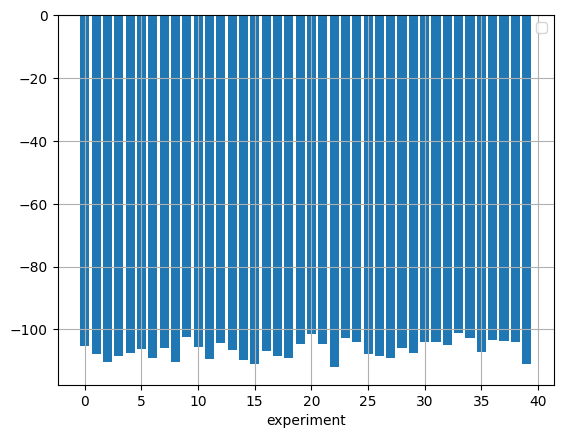

In [17]:
hyperparameter_optimization_results.plot_bar_graph(x_axis='experiment', y_axis='result')

## Pruned Performances

In [18]:
pruned_optuna_trials = [trial for trial in optuna_study.trials if trial.state == optuna.trial.TrialState.PRUNED]

pruned_optuna_trials_per_steps : dict[int, list[optuna.trial.FrozenTrial]] = {} #the pruned trials by the number of completed steps

for pruned_optuna_trial in pruned_optuna_trials:
    
    n_completed_steps = len(pruned_optuna_trial.intermediate_values)
    
    try:
        list_of_pruned = pruned_optuna_trials_per_steps[n_completed_steps]
    
    except:
        list_of_pruned = []
        pruned_optuna_trials_per_steps[n_completed_steps] = list_of_pruned    
        
    list_of_pruned.append(pruned_optuna_trial)
    
    

pruned_trials = [f'configuration_{trial.number + 1}' for trial in optuna_study.trials if trial.state == optuna.trial.TrialState.PRUNED]

print(f"Pruned trials: {pruned_trials}")


Pruned trials: ['configuration_6', 'configuration_10', 'configuration_13', 'configuration_14', 'configuration_15', 'configuration_16', 'configuration_17', 'configuration_18', 'configuration_21', 'configuration_22', 'configuration_23', 'configuration_24', 'configuration_25', 'configuration_26', 'configuration_28', 'configuration_30', 'configuration_31', 'configuration_32', 'configuration_33', 'configuration_34', 'configuration_35', 'configuration_36', 'configuration_38', 'configuration_39', 'configuration_40']


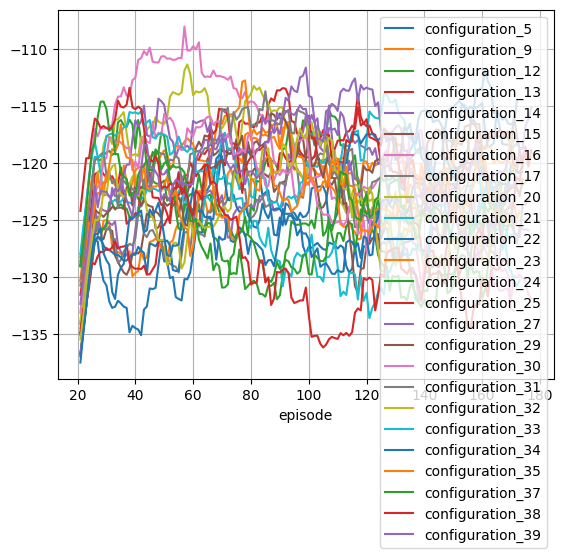

In [19]:
for n_completed_steps in pruned_optuna_trials_per_steps.keys():
    
    pruned_optuna_trials = pruned_optuna_trials_per_steps[n_completed_steps] 
    
    pruned_trials = [f'configuration_{trial.number}' for trial in pruned_optuna_trials ]

    for configuration_name in pruned_trials:
        
        results_logger = results_of_configurations[configuration_name]
    
        #results_logger.plot_graph(x_axis='episode', y_axis=[('total_reward', name)], to_show=False)
        results_logger.plot_confidence_interval(x_axis='episode', y_column='episode_reward',show_std=False, to_show=False, y_values_label=configuration_name, aggregate_number=AGGREGATE_NUMBER)
        #results_logger.plot_linear_regression(x_axis='episode', y_axis='total_reward', to_show=False, y_label=configuration_name + '_linear')
        
    plt.show()

## Completed Trials Evaluation

In [20]:
completed_optuna_trials = [trial for trial in optuna_study.trials if trial.state == optuna.trial.TrialState.COMPLETE]

completed_optuna_trials.sort(key=lambda trial: trial.value) # sort given the trial value

### Worst Completed Performances

In [21]:
N_WORST = 3

In [22]:

worst_optuna_trials = completed_optuna_trials[0:N_WORST]

worst_configurations_to_study = [f"configuration_{trial.number + 1}" for trial in worst_optuna_trials]

print(f"Worst configurations to study: {worst_configurations_to_study}")

Worst configurations to study: ['configuration_2', 'configuration_19', 'configuration_7']


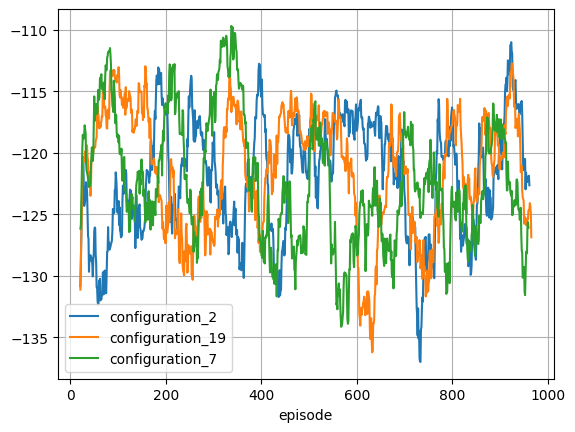

In [23]:
for configuration_name in worst_configurations_to_study:
    
    results_logger = results_of_configurations[configuration_name]

    #results_logger.plot_graph(x_axis='episode', y_axis=[('total_reward', name)], to_show=False)
    results_logger.plot_confidence_interval(x_axis='episode', y_column='episode_reward',show_std=False, to_show=False, y_values_label=configuration_name, aggregate_number=AGGREGATE_NUMBER)
    #results_logger.plot_linear_regression(x_axis='episode', y_axis='total_reward', to_show=False, y_label=configuration_name + '_linear')
    
plt.show()

## Best Performances

In [24]:
N_BEST = 3

In [25]:
best_optuna_trials = completed_optuna_trials[(len(completed_optuna_trials) - 1 - N_BEST):]

best_configurations_to_study = [f"configuration_{trial.number + 1}" for trial in best_optuna_trials]

print(f"Best configurations to study: {best_configurations_to_study}")

Best configurations to study: ['configuration_12', 'configuration_20', 'configuration_29', 'configuration_1']


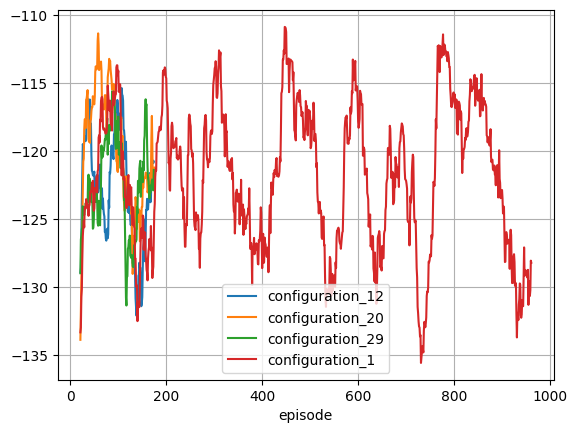

In [26]:
for configuration_name in best_configurations_to_study:
    
    results_logger = results_of_configurations[configuration_name]

    #results_logger.plot_graph(x_axis='episode', y_axis=[('total_reward', name)], to_show=False)
    results_logger.plot_confidence_interval(x_axis='episode', y_column='episode_reward',
                                            show_std=False, to_show=False, 
                                            y_values_label=configuration_name,
                                            aggregate_number=AGGREGATE_NUMBER,
                                            x_slice_range=[0, 100]
                                            )
    #results_logger.plot_linear_regression(x_axis='episode', y_axis='total_reward', to_show=False, y_label=configuration_name + '_linear')
    
plt.show()

# Smaller study

In [32]:
configurations_to_study = ['configuration_12']

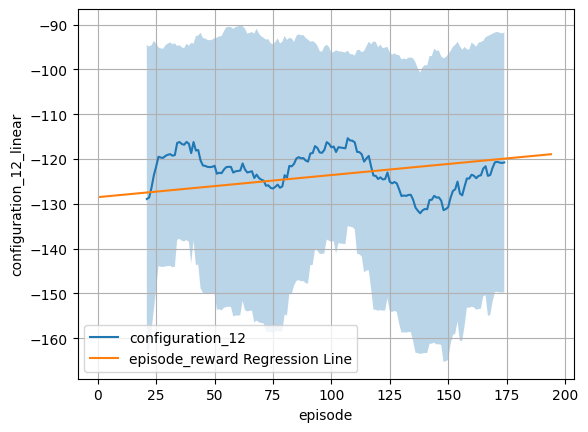

In [33]:

try:

    for configuration_name in configurations_to_study:
    
        results_logger = results_of_configurations[configuration_name]

        #results_logger.plot_graph(x_axis='episode', y_axis=[('total_reward', name)], to_show=False)
        results_logger.plot_confidence_interval(x_axis='episode', y_column='episode_reward',show_std=True, to_show=False, y_values_label=configuration_name, aggregate_number=AGGREGATE_NUMBER)
        results_logger.plot_linear_regression(x_axis='episode', y_axis='episode_reward', to_show=False, y_label=configuration_name + '_linear')
    
    plt.show()

except KeyError as e:
    print(f"KeyError: {e}\nAvailable keys are {results_of_configurations.keys()}")

In [34]:
agents_in_study = []
# agents_in_study = ["agent_1", "agent_2"]

In [35]:
agents_to_study : dict[str, ResultLogger]= {}

for configuration_name in configurations_to_study:
    
    results_logger = results_of_configurations[configuration_name]
    
    for agent_name in agents_in_study:
      
        agent_results_logger = ResultLogger(input={
                                            "logger_directory" : f"{results_logger.lg.logDir}\\{agent_name}",
                                            "filename" : RESULTS_PATH
                                          })

        agents_to_study[f"{configuration_name}_{agent_name}"] = agent_results_logger
        
        agent_results_logger.proccess_input()


In [36]:
for agent_name, agent_results_logger in agents_to_study.items():
    
    #results_logger.plot_graph(x_axis='episode', y_axis=[('total_reward', name)], to_show=False)
    agent_results_logger.plot_confidence_interval(x_axis='episode', y_column='total_reward',show_std=False, to_show=False, y_values_label=agent_name, aggregate_number=AGGREGATE_NUMBER)
    
plt.show()